We introduct a technique for optimization called **simulated annealing**.

Anneal: heat metal and allow it to cool down slowly to toughen it.

In physics, when mental are heated and allowed to cool down slowly. The metal molecules will be arranged to have minimal potential energy. 

Now suppose we have a funciton $f(x)$ whose global minimum needs to be found. We identify this function with the energy of an imaginary physical system undergoing an annealing process. Then, at the end of annealing process we have achieved the mininum of the function.

Suppose at the beginning we have $f(x_i) = E_i$ (E stands for energy). We randomly pick a new $x_j$ whose energy state $f(x_j) = E_j$. The change in the energy due to the state change is $\Delta E= E_j - E_i$.

The move to a new proposition $x_j$ is done via a **proposal**. If $\Delta E \leq 0$ then we move to the new state $x_j$. Otherwise we accept the new state $x_j$ with the probability equal to $$A = exp(-\frac{\Delta E}{kT}),$$

where k is the Bolzmann constant and T is the temperature. This stochastic acceptance of higher energy states, allows our process to escape local minima. We are allowed to **climb the hill**.

When T is high, the probability of accepting a move to higher energy is more. On the other hand, this means as the temperature lowers, there will be more search effort in the current local minimum, since only few uphill moves will be allowed. Thus the cooling schedule is important if we have any hope of getting to the global minimum. 

If the lowering of the temperature is sufficiently slow, the system reaches **thermal equilibrium** at each temperature. Then the Bolzman distribution of state applies  $$p(X = x_i) \propto exp(-\frac{E_i}{kT})$$



Let us consider an example of a function with one global minimum and many local minima.

In [2]:
f = lambda x: x**2 + 4*np.sin(2*x)

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)


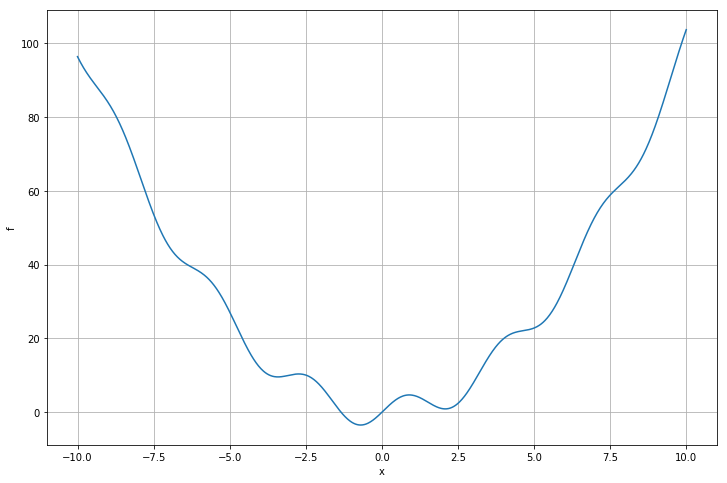

In [10]:
xs = np.linspace(-10.,10.,1000)
plt.plot(xs, f(xs));
plt.xlabel('x')
plt.ylabel('f')
plt.grid()

# Cooling schedule and convergence

The sequence of temperatures and the number of iterations at each temperature consistute the **cooling schedule**.

If we identify $p_{T}(x) \propto e^{-\frac{f(x)}{T}}$ and $p(x) \propto e^{-f(x)}$ then $p_t(x) \propto p(x)^{1/T}$

As $T \rightarrow 0$ you get a peakier distribution around the global minimum. In other words, the distribution of states approaches the opimium  of $f(x)$.

Text(0.5,1,'distribution corresponding to function f')

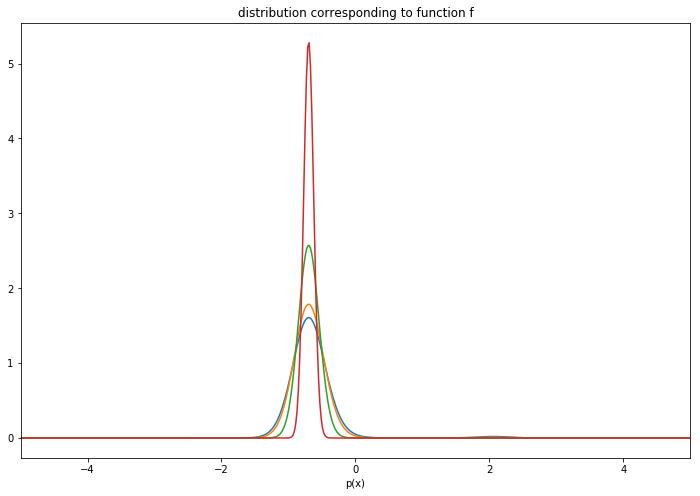

In [26]:
import functools
distx = lambda g, x: np.e**(-g(x))
# limit distx for a partigular g function: g(x) = f(x) see above code
# for definition of f(x)
dxf = functools.partial(distx, f)
outx = np.linspace(-10, 10,1000)
import scipy.integrate as integrate
O=20

# p(x), normalized by integration
plt.plot(outx, dxf(outx)/integrate.quad(dxf,-O, O)[0]);

# p(x) ** 1/T where 1/T = 1.2
A=integrate.quad(lambda x: dxf(x)**1.2,-O, O)[0]
plt.plot(outx, (dxf(outx)**1.2)/A);

# p(x) ** 1/T where 1/T = 2.4, T drops further.
B=integrate.quad(lambda x: dxf(x)**2.4,-O, O)[0]
plt.plot(outx, (dxf(outx)**2.4)/B);

# p(x) ** 1/T where 1/T = 10, T drops further.
C=integrate.quad(lambda x: dxf(x)**10,-O, O)[0]
plt.plot(outx, (dxf(outx)**10)/C);


plt.xlim([-5,5])
plt.xlabel('x')
plt.xlabel('p(x)')
plt.title("distribution corresponding to function f")

# The simulated annealing algorithm

1. Intitialize $x_i$, T, L(T), where L = iterations at a particular temperature.
2. Perform L transitions
    - propose $x_j$
    - if x_j is accepted with probability $P = e^{\Delta E /T}$, set $x_{j + 1} = x_j$, else set $x_{i+1} = x_i$
3. Update T and L, go to 2.

### Proposal distribution

Let us first define our proposal distribution as a normal centers about our current position. In this case we need to figure a width. This is our first case of tuning, the width of our neighborhood 
N
. Notice that this is a symmetric proposal and will thus follow the detailed balance condition.

In [29]:
# proposal distribution
pfxs = lambda s, x: x + s*np.random.normal()
pfxs(0.1, 10)


10.097756156923667

In [33]:
from functools import partial
pf = partial(pfxs, 0.1)
pf(10)

10.022026318224551

## Cooling schedule

Now we must define the functions that constitute our cooling schedule. We reduce the temperature by a multiplicative factor of 0.8, and increase the epoch length by a factor of 1.2

we’ll call the iterations for each temperature an epoch

In [34]:
import math
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

We define the sa function that takes a set of initial conditions, on temperature, length of epoch, and starting point, the energy function, the number or opochs to run, the cooling schedule, and the proposal, and implements the algorithm defined above. Our algorithms structure is that of running for some epochs during which we reduce the temperature and increase the epoch iteration length. This is somewhat wasteful, but simpler to code, although it is not too complex to build in stopping conditions.

In [40]:
# simulated annealing
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    '''
    energyfunc: function f to be optimize
    inits: a dictionary contain some intial parameters
        T: temperature
        solution: intial x
        length: intial L the number of transitions
    '''
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    for index in range(epochs):
        print("Epoch", index)
        if index > 0:
            # decrease temperature
            T = tempfunc(T)
            
            # number of transitions L
            length=iterfunc(length)
        print("Temperature", T, "Length", length)
        for it in range(length):
            total+=1
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator

In [41]:
inits=dict(solution=8, length=100, T=100)
bmeta, bs, be, out = sa(f, inits, 30, tf, itf, pf)


Epoch 0
Temperature 100 Length 100
Epoch 1
Temperature 80.0 Length 120
Epoch 2
Temperature 64.0 Length 144
Epoch 3
Temperature 51.2 Length 173
Epoch 4
Temperature 40.96000000000001 Length 208
Epoch 5
Temperature 32.76800000000001 Length 250
Epoch 6
Temperature 26.21440000000001 Length 300
Epoch 7
Temperature 20.97152000000001 Length 360
Epoch 8
Temperature 16.777216000000006 Length 432
Epoch 9
Temperature 13.421772800000006 Length 519
Epoch 10
Temperature 10.737418240000006 Length 623
Epoch 11
Temperature 8.589934592000004 Length 748
Epoch 12
Temperature 6.871947673600004 Length 898
Epoch 13
Temperature 5.497558138880003 Length 1078
Epoch 14
Temperature 4.398046511104003 Length 1294
Epoch 15
Temperature 3.5184372088832023 Length 1553
Epoch 16
Temperature 2.814749767106562 Length 1864
Epoch 17
Temperature 2.25179981368525 Length 2237
Epoch 18
Temperature 1.8014398509482001 Length 2685
Epoch 19
Temperature 1.4411518807585602 Length 3222
Epoch 20
Temperature 1.1529215046068482 Length 3867

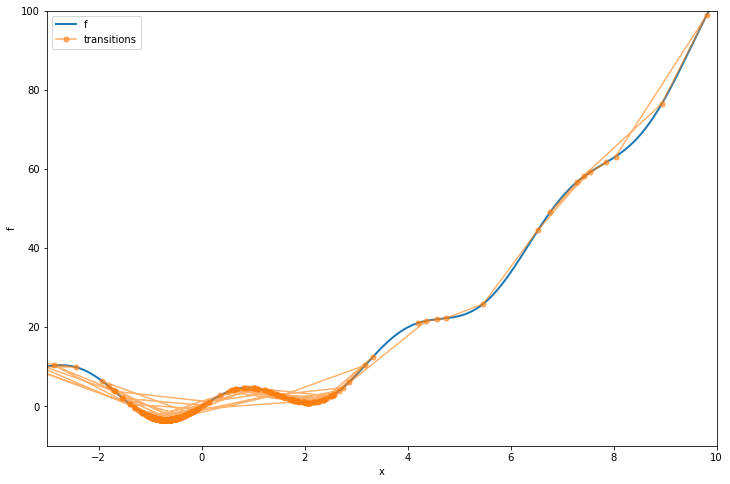

In [42]:
xs = np.linspace(-10.,10.,1000)
plt.plot(xs, f(xs), lw=2, label="f");
eout=list(enumerate(out))
#len([e[1] for i,e in eout if i%100==0]), len([e[2] for i,e in eout if i%100==0])
plt.plot([e[1] for i,e in eout if i%100==0], [e[2] for i,e in eout if i%100==0], 'o-', alpha=0.6, markersize=5, label="transitions")
#plt.plot([e[1] for e in out], [f(e[1]) for e in out], '.', alpha=0.005)
plt.xlim([-3,10])
plt.ylim([-10,100])
plt.xlabel('x')
plt.ylabel('f')
plt.legend();

In [45]:
eout[0]

(0, (100, 8.036801077772836, 63.15998747700342))

 e[1] old solution: e[2] old energy